In [1]:
import pandas as pd
import numpy as np
import cv2
import os

import tensorflow as tf
from tensorflow.keras import models, layers, datasets

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from plotting import show_distribution
from plot_val import calc_roc_curve, plot_roc_curve, plot_confusion_matrix

from apply_processing import apply, resize_images, function_hsv, function_gray
from apply_processing import function_label, blur_images, adjust_contrast_images, rotated_labels
from apply_processing import filter_images, edge_images, contour_images, rotate_images

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Nums GPUs available : {len(physical_devices)}")

tf.config.experimental.set_memory_growth(physical_devices[0], True)

Nums GPUs available : 1


In [3]:
df = pd.read_csv("Dataset\\images_mushrooms.csv")

df.head()

,Image,Label
0,Dataset\Mushrooms\Agaricus\009_mrv34Sn4WiQ.jpg,Agaricus
1,Dataset\Mushrooms\Agaricus\010_Rk1D3EG856g.jpg,Agaricus
2,Dataset\Mushrooms\Agaricus\017_QHGfbEiWvq8.jpg,Agaricus
3,Dataset\Mushrooms\Agaricus\020_vZJfrjIwmqU.jpg,Agaricus
4,Dataset\Mushrooms\Agaricus\030_-i6kYqDvBQo.jpg,Agaricus


In [4]:
df_test = pd.read_csv("Dataset\\test_images_mushrooms.csv")

df_test.head()

,Image,Label
0,Dataset\Test Mushrooms\Agaricus\006_1_E6AXBJqn...,Agaricus
1,Dataset\Test Mushrooms\Agaricus\043_UPu2ng0N0z...,Agaricus
2,Dataset\Test Mushrooms\Agaricus\053_MKIISBeGQF...,Agaricus
3,Dataset\Test Mushrooms\Agaricus\055_Cggc3hvlPf...,Agaricus
4,Dataset\Test Mushrooms\Agaricus\065_ca8G5lwf7C...,Agaricus


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   900 non-null    object
 1   Label   900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   450 non-null    object
 1   Label   450 non-null    object
dtypes: object(2)
memory usage: 7.2+ KB


In [7]:
df['Label'].value_counts() / df.shape[0]

Russula        0.111111
Agaricus       0.111111
Cortinarius    0.111111
Suillus        0.111111
Boletus        0.111111
Amanita        0.111111
Lactarius      0.111111
Hygrocybe      0.111111
Entoloma       0.111111
Name: Label, dtype: float64

In [8]:
df_test['Label'].value_counts() / df_test.shape[0]

Hygrocybe      0.111111
Agaricus       0.111111
Cortinarius    0.111111
Suillus        0.111111
Russula        0.111111
Boletus        0.111111
Amanita        0.111111
Lactarius      0.111111
Entoloma       0.111111
Name: Label, dtype: float64

# Processing the images

In [9]:
def processing_noAug(df):
    images = df['Image']
    labels = df["Label"]
    
    size = (150, 150)
    
    mod_images = function_hsv(images)
    mod_images = resize_images(mod_images, size)
    mod_images = filter_images(mod_images)
    mod_images = adjust_contrast_images(mod_images, contrast=1.75, brightness=50)
    mod_images = blur_images(mod_images)
    
    return mod_images, labels

train_images, train_labels = processing_noAug(df)
test_images, test_labels = processing_noAug(df_test)

# Images info

In [10]:
print(f"Length of train images no augmentation {len(train_images)}")
print(f"Length of train labels no augmentation {len(train_labels)}")

Length of train images no augmentation 900
Length of train labels no augmentation 900


In [11]:
print(f"Length of test images no augmentation {len(test_images)}")
print(f"Length of test labels no augmentation {len(test_labels)}")

Length of test images no augmentation 450
Length of test labels no augmentation 450


# Modelling

In [12]:
le = LabelEncoder()
le.fit(train_labels)

LabelEncoder()

In [13]:
train_labels = le.transform(train_labels)
train_images = np.array(train_images) / 255.0

test_labels = le.transform(test_labels)
test_images = np.array(test_images)/ 255.0

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        18464     
Total params: 95,840
Trainable params: 95,840
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(9))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               6

In [18]:
adam_callback = tf.keras.callbacks.TensorBoard(log_dir='CNN_board/adam', histogram_freq=1)
sgd_callback = tf.keras.callbacks.TensorBoard(log_dir='CNN_board/sgd', histogram_freq=1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
save_path = "save_model/HSV_noAug/cnn_hsv_noAug.ckpt"
filename = "save_model/HSV_noAug/cnn_hsv_noAug.ckpt.index"

if os.path.isfile(filename):
    model.load_weights(save_path)
else:
    print("There's no checkpoint yet")
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(save_path, save_weights_only=True, save_best_only=True)

In [20]:
# open this to training the model

# model_training = model.fit(train_images, train_labels, epochs=100, 
#                            validation_data=(test_images, test_labels), batch_size=32, callbacks=[cp_callback])

In [21]:
model.evaluate(test_images, test_labels)

15/15 [==============================] - 10s 244ms/step - loss: 2.0034 - accuracy: 0.2556


[2.0034279823303223, 0.25555557012557983]

## Evaluation

### ROC and AUC

In [22]:
model_proba = model.predict(test_images)

In [23]:
fprs, tprs, aucs = calc_roc_curve(test_labels, model_proba)

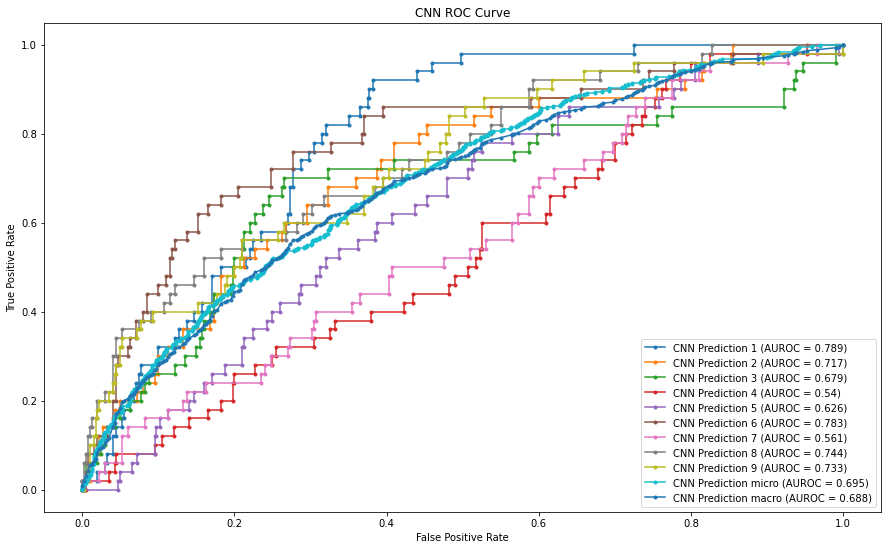

In [24]:
fig, ax = plt.subplots(figsize=(15,9))

plot_roc_curve(fprs, tprs, aucs, "CNN")

### Confusion Matrix

In [25]:
model_pred = np.argmax(model.predict(test_images), axis=1)

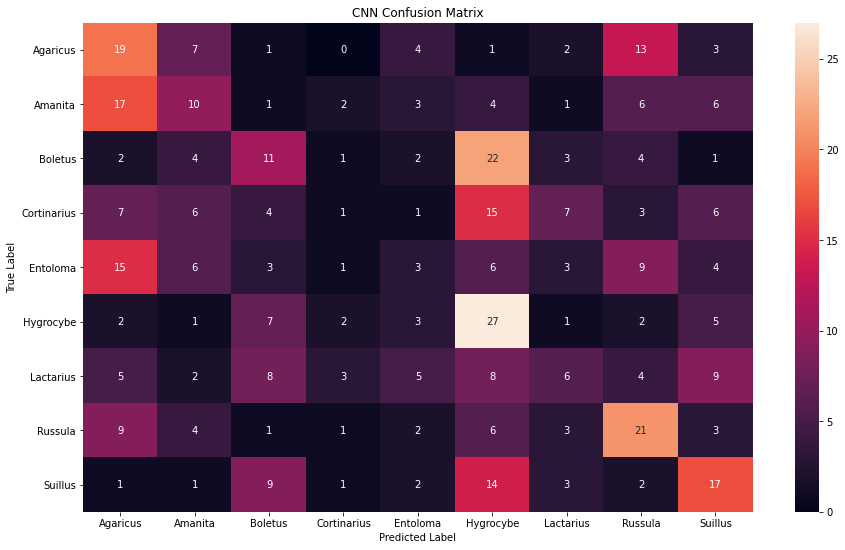

In [26]:
fig, ax = plt.subplots(figsize=(15, 9))

plot_confusion_matrix(le.inverse_transform(test_labels), test_labels, model_pred, 'CNN')